In [1]:
#!pip install tensorflow==1.14.0

In [2]:
#!pip install keras==2.2.5

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import gc
import warnings

import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [5]:
site_id = 12

In [6]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

df_train = df_train[~((df_train.building_id.isin([1035, 1041, 1045, 1049, 1050, 1051, 1053, 1060, 1062, 1063, 1064, 1065, 1066])) & (df_train.log_meter_reading < 1))]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

del building
gc.collect()

0

In [7]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [8]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [9]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [10]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 12 and meter 0
Preparing Site: 12 , meter: 0 , Fold: 1




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 236628 samples, validate on 78876 samples
Epoch 1/41
 - 6s - loss: 3.9008 - val_loss: 2.7657
Epoch 2/41
 - 4s - loss: 2.6608 - val_loss: 1.4262
Epoch 3/41
 - 4s - loss: 1.5384 - val_loss: 1.2821
Epoch 4/41
 - 3s - loss: 1.3426 - val_loss: 1.3006
Epoch 5/41
 - 3s - loss: 1.3117 - val_loss: 1.3013
Epoch 6/41
 - 4s - loss: 1.3005 - val_loss: 1.2997
Epoch 7/41
 - 4s - loss: 1.2892 - val_loss: 1.2974
Epoch 8/41
 - 4s - loss: 1.2825 - val_loss: 1.2951
Epoch 9/41
 - 4s - loss: 1.2723 - val_loss: 1.2944
Epoch 10/41
 - 4s - loss: 1.2622 - val_loss: 1.2914
Epoch 11/41
 - 3s - loss: 1.2555 - val_loss: 1.2911
Epoch 12/41
 - 3s - loss: 1.2451 - val_loss: 1.2857
Epoch 13/41
 - 3s - loss: 1.2357 - va

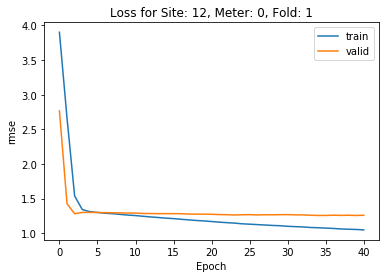

Preparing Site: 12 , meter: 0 , Fold: 2
Train on 236628 samples, validate on 78876 samples
Epoch 1/41
 - 5s - loss: 3.5720 - val_loss: 3.3211
Epoch 2/41
 - 4s - loss: 2.3668 - val_loss: 1.7514
Epoch 3/41
 - 3s - loss: 1.5670 - val_loss: 1.1593
Epoch 4/41
 - 3s - loss: 1.4417 - val_loss: 1.0526
Epoch 5/41
 - 3s - loss: 1.4075 - val_loss: 1.0205
Epoch 6/41
 - 3s - loss: 1.3909 - val_loss: 1.0079
Epoch 7/41
 - 3s - loss: 1.3817 - val_loss: 0.9924
Epoch 8/41
 - 4s - loss: 1.3726 - val_loss: 0.9803
Epoch 9/41
 - 3s - loss: 1.3644 - val_loss: 0.9755
Epoch 10/41
 - 3s - loss: 1.3571 - val_loss: 0.9629
Epoch 11/41
 - 3s - loss: 1.3500 - val_loss: 0.9632
Epoch 12/41
 - 3s - loss: 1.3429 - val_loss: 0.9613
Epoch 13/41
 - 5s - loss: 1.3349 - val_loss: 0.9490
Epoch 14/41
 - 4s - loss: 1.3319 - val_loss: 0.9416
Epoch 15/41
 - 4s - loss: 1.3236 - val_loss: 0.9421
Epoch 16/41
 - 4s - loss: 1.3143 - val_loss: 0.9293
Epoch 17/41
 - 4s - loss: 1.3081 - val_loss: 0.9271
Epoch 18/41
 - 4s - loss: 1.3021 -

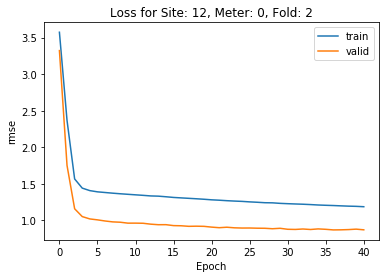

Preparing Site: 12 , meter: 0 , Fold: 3
Train on 236628 samples, validate on 78876 samples
Epoch 1/41
 - 4s - loss: 3.6195 - val_loss: 3.2002
Epoch 2/41
 - 3s - loss: 2.4070 - val_loss: 1.6457
Epoch 3/41
 - 3s - loss: 1.6112 - val_loss: 1.0877
Epoch 4/41
 - 3s - loss: 1.4595 - val_loss: 0.9946
Epoch 5/41
 - 3s - loss: 1.4208 - val_loss: 0.9736
Epoch 6/41
 - 3s - loss: 1.4018 - val_loss: 0.9629
Epoch 7/41
 - 3s - loss: 1.3909 - val_loss: 0.9494
Epoch 8/41
 - 3s - loss: 1.3821 - val_loss: 0.9463
Epoch 9/41
 - 3s - loss: 1.3758 - val_loss: 0.9356
Epoch 10/41
 - 4s - loss: 1.3688 - val_loss: 0.9345
Epoch 11/41
 - 3s - loss: 1.3618 - val_loss: 0.9294
Epoch 12/41
 - 3s - loss: 1.3544 - val_loss: 0.9202
Epoch 13/41
 - 3s - loss: 1.3490 - val_loss: 0.9260
Epoch 14/41
 - 3s - loss: 1.3421 - val_loss: 0.9260
Epoch 15/41
 - 3s - loss: 1.3363 - val_loss: 0.9190
Epoch 16/41
 - 3s - loss: 1.3293 - val_loss: 0.9173
Epoch 17/41
 - 3s - loss: 1.3234 - val_loss: 0.9193
Epoch 18/41
 - 3s - loss: 1.3158 -

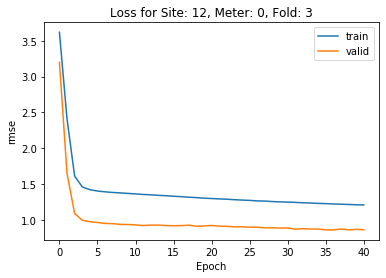

Preparing Site: 12 , meter: 0 , Fold: 4
Train on 236628 samples, validate on 78876 samples
Epoch 1/41
 - 5s - loss: 3.7248 - val_loss: 3.0757
Epoch 2/41
 - 3s - loss: 2.5022 - val_loss: 1.4719
Epoch 3/41
 - 3s - loss: 1.5777 - val_loss: 0.9915
Epoch 4/41
 - 4s - loss: 1.4380 - val_loss: 0.9882
Epoch 5/41
 - 4s - loss: 1.4092 - val_loss: 0.9895
Epoch 6/41
 - 4s - loss: 1.3982 - val_loss: 0.9883
Epoch 7/41
 - 4s - loss: 1.3885 - val_loss: 0.9867
Epoch 8/41
 - 4s - loss: 1.3806 - val_loss: 0.9858
Epoch 9/41
 - 4s - loss: 1.3686 - val_loss: 0.9830
Epoch 10/41
 - 4s - loss: 1.3637 - val_loss: 0.9823
Epoch 11/41
 - 4s - loss: 1.3567 - val_loss: 0.9780
Epoch 12/41
 - 3s - loss: 1.3484 - val_loss: 0.9780
Epoch 13/41
 - 3s - loss: 1.3402 - val_loss: 0.9779
Epoch 14/41
 - 3s - loss: 1.3354 - val_loss: 0.9742
Epoch 15/41
 - 4s - loss: 1.3272 - val_loss: 0.9729
Epoch 16/41
 - 3s - loss: 1.3191 - val_loss: 0.9754
Epoch 17/41
 - 3s - loss: 1.3122 - val_loss: 0.9748
Epoch 18/41
 - 4s - loss: 1.3037 -

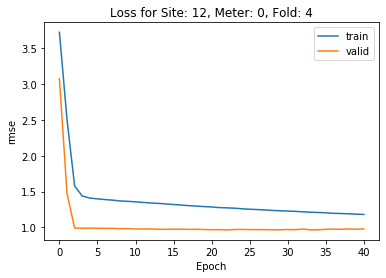


CV RMSE for Site: 12 and Meter: 0 is 1.1030524112586484

CV RMSE for Site: 12 is 1.1030524112586484


In [11]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(16, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=41, batch_size=1000, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [14]:
#df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)